In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

We define some functions involved. Use the formulations that avoid overflows.  
1. sigmoid function sigmoid(t)
2. log of sigmoid(t), called log_sig(t)
3. log of 1-sigmoid = 1/(1+e^t), called log_one_sig(t)
4. cross-entropy loss function given the inputs of label y and prediction y_hat = sigmoid(z), where y, y_hat, and z are vectors of dimension N. (N = # of data points.) You should implement this function with z, rather than y_hat, as the input; namely, the loss function should be

    loss = -y log(sigmoid(z)) - (1-y) log (1-sigmoid(z))

  where log(sigmoid(z)) and log (1-sigmoid(z)) should be computed by the functions log_sig(z) and log_one_sig(z) in parts 2 and 3.

In [ ]:
def sigmoid(t):
    return 1.0/(1 + np.exp(-t))

def loss(y, z):
    # compute loss(y, sigmoid(z))
    # y --> label
    # z --> model output

    loss = np.mean(-y*(mylog(z)) - (1-y)*mylogminus(z))
    return loss

def mylog(t):
    # compute log(sigmoid(t)) to be used in loss

    y = 0*t
    m=t.shape[0]
    for i in range(m):
      if t[i] < 0:
        y[i] = t[i]-np.log(1+np.exp(t[i]))
      else:
        y[i] = -np.log(1+np.exp(-t[i]))

    return y

def mylogminus(t):
    # compute log(1-sigmoid(t)) to be used in loss

    y = 0*t
    m=t.shape[0]
    for i in range(m):
      if t[i] < 0:
        y[i] = -np.log(1+np.exp(t[i]))
      else:
        y[i] = -t[i]- np.log(1+np.exp(-t[i]))

    return y


We define the ReLU function and its derivative ReLUprime

In [ ]:
def ReLU(t):
  # Maximum of 0 and t
  return np.maximum(0, t)

def ReLUprime(t):
  return (t > 0).astype(float)


Define the neural network function with one hidden layer. Your function should take the data matrix X (N-by-n matrix) containing N input points and produce a vector of dimension N containing N output values, one for each data point for the binary classification. The function should also take as inputs the model parameters:

output layer: w (n-dimensional weigth vector), b (bias),

hidden layer: W_one (n_one-by-n matrix), and b_one (n_one dimensional vector).

Use ReLU as the nonlinear activation function.

In [ ]:
def model(w, b, W_one, b_one, X):

  # Parameters:
  # X --> N-by-n Input.
  # z --> model output.
  # w --> output layer weight.
  # b --> output layer bias.
  # W_one --> hidden layer weight.
  # b_one --> hidden layer bias.

  # First Hidden Layer
  a_one = X @ W_one.T + b_one
  h_one = ReLU(a_one)

  # Output layer
  z = h_one @ w + b

  return(z)

Define the function that generates the output of the neural network and the gradient of the cross-entropy loss using the forward and backward propagation algorithms. The forward propagation should be the same as your *model(w, b, W_one, b_one, X)*.

The function takes the data matrix X (N-by-n matrix), the label y (N-vector), and the model parameters (w, b, W_one, b_one) as inputs and produces network output z, the gradients dw, db, dW_one, db_one as outputs.

This implementation computes the gradient for each data point at a time through a loop. It is possible to take the entire data matrix and compute the mean gradient as in the linear models before, but that is more complicated to code and is not required.

In [ ]:
def gradients(w, b, W_one, b_one, X, y):

    # Parameters:
    # X --> N-by-n Input.
    # z --> model output.
    # w --> output layer weight.
    # b --> output layer bias.
    # W_one --> hidden layer weight.
    # b_one --> hidden layer bias.

    N = X.shape[0]

    # Init gradients
    dw = np.zeros(w.shape)
    db = 0
    dW_one = np.zeros(W_one.shape)
    db_one = np.zeros_like(b_one)

    # Forward Propogation
    z = model(w, b, W_one, b_one, X)

    # Compute sigmoid of z
    sig_z = sigmoid(z)

    for i in range(N):
      # extract sample
      x_i = X[i].reshape(1, -1)
      y_i = y[i]
      z_i = z[i]

      # forward prop, same as model function. We need a and h from it though, so we cannot reuse the function.
      a_one_i = x_i @ W_one.T + b_one
      h_one_i = ReLU(a_one_i)

      sig_i = sigmoid(z_i)

      # cross-entropy loss
      dz_i = sig_i - y_i

      # Back Prop
      # update gradients
      dw += dz_i * h_one_i[0]
      db += dz_i

      dh_one_i = dz_i * w
      da_one_i = dh_one_i * ReLUprime(a_one_i)

      # Update hidden layer gradients
      dW_one += np.outer(dz_i * ReLUprime(a_one_i), x_i)
      db_one += da_one_i[0]

    # Normalize gradients
    dw /= N
    db /= N
    dW_one /= N
    db_one /= N

    return z, dw, db, dW_one, db_one


Trains the neural network by the gradient descent algorithm using a fixed number of iteration (*iter*) and learning rate (*lr*). The function should takes *iter* and *lr* as well as the initial parameters, the input data X and the label y as the inputs. It produces new parameters as output. Also computes the loss value at each iteration and output the sequence of the loss.

In [ ]:
def train(w, b, W_one, b_one, X, y, iter, lr):

  # Parameters:
  # X --> N-by-n Input.
  # z --> model output.
  # w --> output layer weight.
  # b --> output layer bias.
  # W_one --> hidden layer weight.
  # b_one --> hidden layer bias.
  # iter --> number of iterations
  # lr --> Learning rate.

  losses = []

  for i in range(iter):
    # Calculate gradient
    z, dw, db, dW_one, db_one = gradients(w, b, W_one, b_one, X, y)

    # Update weights
    w -= lr * dw
    b -= lr * db
    W_one -= lr * dW_one
    b_one -= lr * db_one

    # Calculate binary cross-entroly loss
    y_hat = sigmoid(z)
    l = loss(y, z)

    losses.append(l)

  return w, b, W_one, b_one, losses

1. *predict()* produces class prediction label y_label (N-vector of 0 or 1) given the model output z.

2. *accuracy()* computes the accuracy of prediction.



In [ ]:
def predict(output):

    # output --> model output z
    # pred_class --> model class prediction

    pred_class = (output > 0).astype(int)
    return np.squeeze(pred_class)

def accuracy(y, y_predict):
    accuracy = np.sum(y == y_predict) / len(y)
    return accuracy


We test the code on the half moon dataset. The code below  uses l_one = 150 neurons in the hidden layer and the weights are initialized to be the stadard random normal distribution N(0,1). You may also try the Xavier Glorot and Kaiming He initializations but it is not important for this single layer network. You should tune at least 4 learning rates. Your best accuracy should well exceed 95% with a loss below 0.1.

0.996
0.996


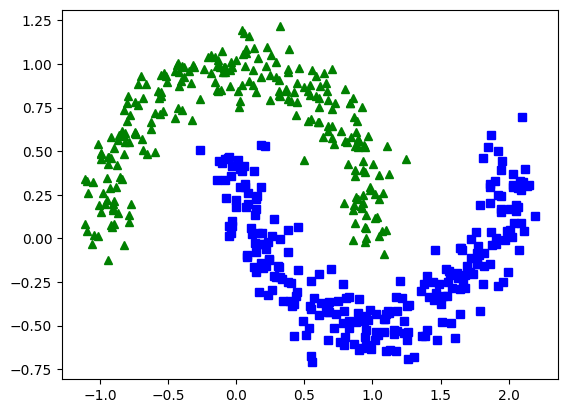

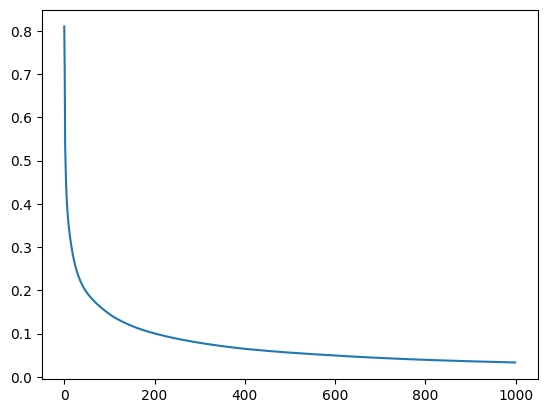

In [ ]:
from sklearn.datasets import make_moons
X_train, y_train = make_moons(n_samples=500, noise=0.1)
X_test, y_test = make_moons(n_samples=1000, noise=0.1)

plt.figure()
plt.plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "g^")
plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bs")

# initialization
l_one=150
n=X_train.shape[1]
w=np.random.randn(l_one)
b = 0
W_one = np.random.randn(l_one, X_train.shape[1])
b_one = 0*np.random.rand(l_one)

# train
w, b, W_one, b_one, losses = train(w, b, W_one, b_one, X_train, y_train, iter=1000, lr=0.1)

# print results
plt.figure()
plt.plot(losses)

#training accuracy
z = model(w,b,W_one, b_one,X_train)
acc = accuracy(np.squeeze(y_train), predict(np.squeeze(z)))
print(acc)

# testing accuracy
z = model(w,b,W_one, b_one,X_test)
acc = accuracy(np.squeeze(y_test), predict(np.squeeze(z)))

print(acc)